# <center> News Classification with NLP and Neural Networks</center>

### Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow as tf
from sklearn import preprocessing
import plotly.graph_objects as go

from keras import models
from keras import layers
from keras import optimizers
from keras.utils.np_utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer


warnings.filterwarnings('ignore')

### Data
- Import JSON file
- Limit to top categories

In [2]:
# Read in json file to DataFrame
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)

# View Results
print(df.shape)
df.sample(5)

(200853, 6)


,category,headline,authors,link,short_description,date
187091,SCIENCE,Northern Lights: Sweden's Night Sky Swirls Wit...,,https://www.huffingtonpost.com/entry/northern-...,April Auroras: Dazzling Photos of Northern Lig...,2012-06-24
23745,WORLD NEWS,Russia's Military Says It May Have Killed ISIS...,"Dmitry Solovyov and Ahmed Rasheed, Reuters",https://www.huffingtonpost.com/entry/airstrike...,The airstrike targeted a meeting of ISIS leade...,2017-06-16
71050,ENTERTAINMENT,7 'Star Wars' Theories That'll Change How You ...,Bill Bradley,https://www.huffingtonpost.com/entry/star-wars...,These are the theories you're looking for.,2015-12-26
179532,MONEY,Free Money Day: On Lehman Brothers' Death Anni...,Catherine New,https://www.huffingtonpost.com/entry/free-mone...,"For Wall Street, Saturday is a gloomy annivers...",2012-09-14
103657,SPORTS,Here's How A Former NBA Prospect Found Out His...,Chris Branch,https://www.huffingtonpost.com/entry/isaiah-au...,,2014-12-19


# Cleaning

#### Check data types

#### Check NaNs 

#### Check Duplicates

In [3]:
print(f"There are {df.duplicated().sum()} duplicated rows")

# Drop duplicates
df = df.drop_duplicates()

print(f"There are now {df.duplicated().sum()} duplicated rows")

There are 13 duplicated rows
There are now 0 duplicated rows


### Dates

In [4]:
df['date'] = df['date'].dt.year

#### Authors 
- The `authors` field is a list containing:
    - Name(s)
    - Titles
    - Organizations
    - Misc comments
- It also contains many NaNs in the form of empty strings
- Approach:
    - Replace NaNs with 'unknown'
    - Extract author names from the field, create new field named `author_names` to be used as a bigram
    - Leave the rest of the information in a new field named `author_notes`

### Author Names
- Replace missing
- Get Names
- Clean non-name details
- Cast as strings

In [5]:
# Replace missing authors with 'unknown'
df['authors'] = df['authors'].apply(lambda x: x.replace('','unknown') if x == '' else x)

In [6]:
# Get author names from list
df['author_names'] = df['authors'].apply(lambda x: x.replace('By','').strip().split(',')[0].lower().split(' And '))

In [7]:
# Clean up common formatting issues
df['authors'] = df['authors'].apply(lambda x: x.replace('By','').replace('\n','').replace('Contributor','Contributor ').strip())

### Links
- The links are not helpful in their current form, need to extract keyworks from them

In [8]:
# Replace charaters we want to split on with commas, then split, only get the relevant entries from the resulting list
df['link_keywords'] = df['link'].apply(lambda x: x.replace('-',',').replace("_",',').replace("entry/",',').split(',')[1:-2])

# Typecast from list to string
df['link_keywords'] = df['link_keywords'].apply(lambda x: ' '.join(x))

### Join all text columns

In [9]:
df['text'] = df['headline'] + ' ' + df['short_description'] + ' ' + df['link_keywords'] + ' ' + df['authors'] + ' ' + df['date'].astype(str)

### Drop unwanted features

In [10]:
# Drop the feature if it appear in the colums (done this way so the cell can be re-run)
df = df.drop(columns=[col for col in df.columns if col in ['link','authors','headline','short_description','date','link_keywords','author_notes','author_names']])

# View Sample
df.sample(5)

,category,text
100774,TRAVEL,How To Work When You're On The Road For the pa...
98059,CRIME,Officials Investigate Suspicious Death Of Inma...
140895,WELLNESS,"Running Form: Distilled (Part 4) But, since ch..."
9454,POLITICS,Republicans Are Voting To Give A Huge Tax Cut ...
100551,BUSINESS,"Women in Business Q&A: Kimberly Gordon, CEO & ..."


# <center> -------------------------------------------------------------------- </center>

# EDA

#### View categories

#### View length of texts

### Author Activity

# <center> -------------------------------------------------------------------- </center>

# Preprocessing Text Data
- Remove all words that only appear once throughout all texts (lead to overfitting)
- Stop words
- Stem / Lemmatize text
- Tokenization
- Use all words or just most frequent?
- Use bigrams, POS taggins, Mutual information Scores?
- What sort of vectorization? (Boolean / Count / TF-IDF / Word2Vec)

In [11]:
# Get count of all unique words
word_dict = {}

for text in df['text']:
    for word in text.split():
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] += 1

In [12]:
words_that_dont_appear_more_than_once = [word for word,count in word_dict.items() if count < 2]

In [13]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

### Encode Target Variable
- Assign a unique value to each categories

In [14]:
# Instantiate label encoder 
le = preprocessing.LabelEncoder()

# Label Encode categories
df['class_label'] = le.fit_transform(df['category'])

# Create dictionary to map labels to categories
label_to_category = dict(df.groupby('class_label')['category'].first())

### Test Train Split

In [15]:
from sklearn.model_selection import train_test_split

# Define dependent and independent variables
X = df["text"]
y = df["class_label"]

# Perform Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=8)

#### OHE target

In [16]:
from keras.utils.np_utils import to_categorical

# OHE for netural network
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
y_val_ohe = to_categorical(y_val)

### Get Stopwords

In [17]:
stopwords_list = stopwords.words('english') + list(string.punctuation) + ["''", '""', '...', '``'] + words_that_dont_appear_more_than_once

### Count Vectorization

In [18]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (ps.stem(word) for word in analyzer(doc))

In [19]:
# Instantiate CountVectorizer with custom list of stop words
count_vectorizer = CountVectorizer(stop_words= stopwords_list, analyzer=stemmed_words)

# Fit the tokenizer on the training data
count_vectorizer.fit(X_train)

# Apply the tokenizer to the training and testing data
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)
X_val_counts = count_vectorizer.transform(X_val)

# View Results
print(f'There are {X_train_counts.shape[0]} observations and {X_train_counts.shape[1]} features')

There are 128537 observations and 68200 features


## Model: Neural Network

#### Create model
- Fully connected (dense) layer network with relu activation
- 2 hidden layers with 50 units in 1st and 25 in second
- Softmax classifier for nulticlass problem

In [20]:
# Initialize a sequential model
model = models.Sequential()

# Two layers with relu activation
model.add(layers.Dense(50, activation='relu'))

# One layer with softmax activation 
model.add(layers.Dense(41, activation='softmax'))

#### Compile
- Loss function = categorical crossentropy
- Optimizer = stochastic gradient descent

In [21]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [26]:
# Train the model 
n_epochs = 100
history = model.fit(X_train_counts, y_train_ohe, epochs= n_epochs, validation_data = (X_val_counts, y_val_ohe))

Epoch 1/100
4017/4017 [==============================] - 6s 1ms/step - loss: 0.4879 - acc: 0.8632 - val_loss: 0.8540 - val_acc: 0.7550
Epoch 2/100
4017/4017 [==============================] - 6s 1ms/step - loss: 0.4701 - acc: 0.8683 - val_loss: 0.8546 - val_acc: 0.7562
Epoch 3/100
4017/4017 [==============================] - 6s 1ms/step - loss: 0.4532 - acc: 0.8730 - val_loss: 0.8544 - val_acc: 0.7573
Epoch 4/100
4017/4017 [==============================] - 6s 1ms/step - loss: 0.4367 - acc: 0.8782 - val_loss: 0.8533 - val_acc: 0.7577
Epoch 5/100
4017/4017 [==============================] - 5s 1ms/step - loss: 0.4209 - acc: 0.8840 - val_loss: 0.8599 - val_acc: 0.7557
Epoch 6/100
4017/4017 [==============================] - 6s 1ms/step - loss: 0.4064 - acc: 0.8881 - val_loss: 0.8618 - val_acc: 0.7554
Epoch 7/100
4017/4017 [==============================] - 6s 1ms/step - loss: 0.3921 - acc: 0.8933 - val_loss: 0.8625 - val_acc: 0.7571
Epoch 8/100
4017/4017 [==============================] 

### Evaluation

In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_model_metrics(actuals, predictions, full_report = False, plot = False):  

    predictions_bool = np.argmax(predictions, axis=1)
    
    precision = round(precision_score(actuals, predictions_bool, average='weighted'),3)
    recall = round(recall_score(actuals, predictions_bool, average='weighted'),3)
    f1 = round(f1_score(actuals, predictions_bool, average='weighted'),3)
    accuracy = round(accuracy_score(actuals, predictions_bool),3)
    
    if full_report == False:
        print(f"Accuracy = {accuracy} \nPrecision = {precision} \nRecall = {recall} \nf1 = {f1}")
    else:
        print(classification_report(actuals, predictions_bool))
    if plot == True:
        fig = go.Figure()

        fig.add_trace(go.Scatter(x=[i for i in range(n_epochs)], y=history.history['acc'],
                            mode='lines+markers', name='Train Accuracy'))
        fig.add_trace(go.Scatter(x=[i for i in range(n_epochs)], y=history.history['val_acc'],
                            mode='lines+markers', name='Validation Accuracy'))

        fig.update_layout(height= 500, width= 700)

        fig.show()

Accuracy = 0.743 
Precision = 0.742 
Recall = 0.743 
f1 = 0.742


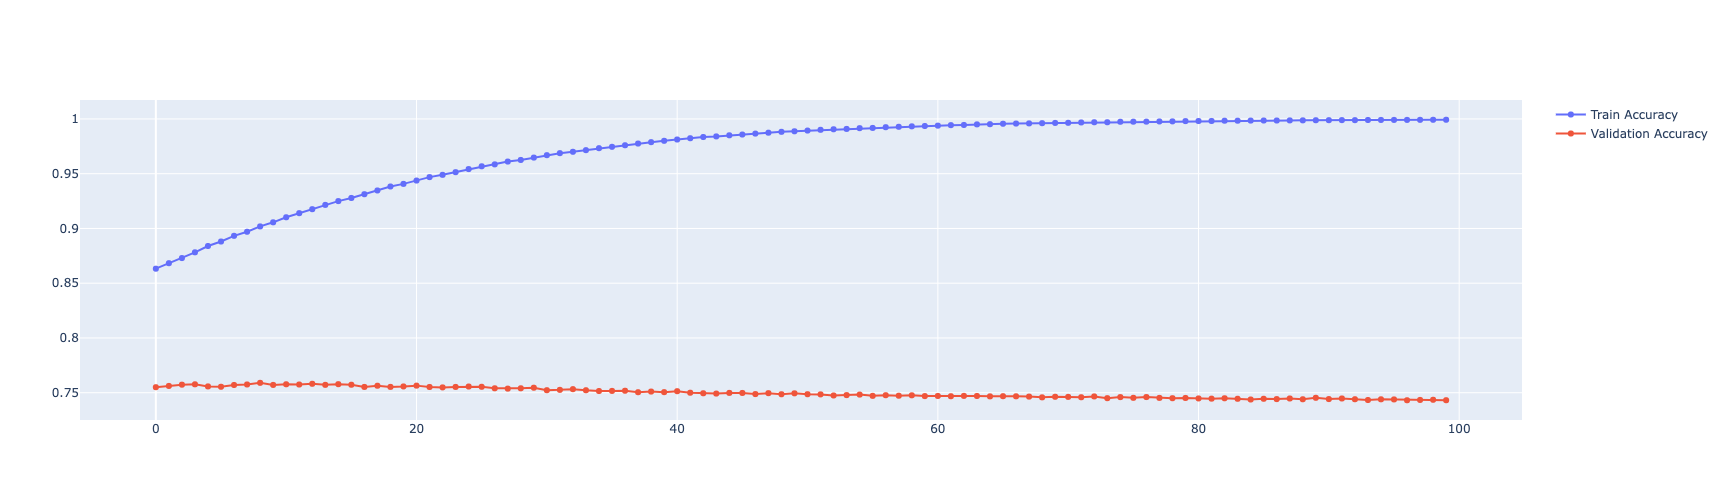

In [28]:
get_model_metrics(y_val, model.predict(X_val_counts), full_report = 0, plot = 1)

### TFIDF Vectorization
- Weigh words by how frequently they appear in the dataset, discount words that are too common (noise)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate CountVectorizer with custom list of stop words
tf_idf_vectorizer = TfidfVectorizer(stop_words= stopwords_list)

# Fit the tokenizer on the training data
tf_idf_vectorizer.fit(X_train)

# Apply the tokenizer to the training and testing data
X_train_tf_idf = tf_idf_vectorizer.transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)
X_val_tf_idf = tf_idf_vectorizer.transform(X_val)

# View Results
print(f'There are {X_train_counts.shape[0]} observations and {X_train_counts.shape[1]} features')

There are 128537 observations and 93540 features


## Model: Neural Network

#### Create model

In [24]:
# Initialize a sequential model
model_tf_idf = models.Sequential()

# Two layers with relu activation
model_tf_idf.add(layers.Dense(50, activation='relu'))

# One layer with softmax activation 
model_tf_idf.add(layers.Dense(41, activation='softmax'))

#### Compile
- Loss function = categorical crossentropy
- Optimizer = stochastic gradient descent

In [25]:
model_tf_idf.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['acc'])

#### Format DataTypes

In [26]:
# Define function to turn sparse matrix to sparse tensor
def to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

# Apply function to matricies
X_train_tf_idf_tensor = tf.sparse.reorder(to_sparse_tensor(X_train_tf_idf))
X_val_tf_idf_tensor = tf.sparse.reorder(to_sparse_tensor(X_val_tf_idf))

In [27]:
# Train the model 
## 50 not enough
n_epochs = 200
history = model_tf_idf.fit(X_train_tf_idf_tensor, y_train_ohe, epochs= n_epochs, validation_data = (X_val_tf_idf_tensor, y_val_ohe))

Epoch 1/200
4017/4017 [==============================] - 6s 1ms/step - loss: 3.3443 - acc: 0.1637 - val_loss: 3.2708 - val_acc: 0.1633
Epoch 2/200
4017/4017 [==============================] - 5s 1ms/step - loss: 3.2556 - acc: 0.1638 - val_loss: 3.2432 - val_acc: 0.1633
Epoch 3/200
4017/4017 [==============================] - 5s 1ms/step - loss: 3.2179 - acc: 0.1638 - val_loss: 3.1927 - val_acc: 0.1636
Epoch 4/200
4017/4017 [==============================] - 6s 1ms/step - loss: 3.1535 - acc: 0.1806 - val_loss: 3.1167 - val_acc: 0.2168
Epoch 5/200
4017/4017 [==============================] - 6s 1ms/step - loss: 3.0740 - acc: 0.2376 - val_loss: 3.0365 - val_acc: 0.2637
Epoch 6/200
4017/4017 [==============================] - 5s 1ms/step - loss: 2.9948 - acc: 0.2736 - val_loss: 2.9577 - val_acc: 0.2806
Epoch 7/200
4017/4017 [==============================] - 5s 1ms/step - loss: 2.9143 - acc: 0.3077 - val_loss: 2.8755 - val_acc: 0.3241
Epoch 8/200
4017/4017 [==============================] 

KeyboardInterrupt: 

### Evaluation

Accuracy = 0.762 
Precision = 0.76 
Recall = 0.762 
f1 = 0.759


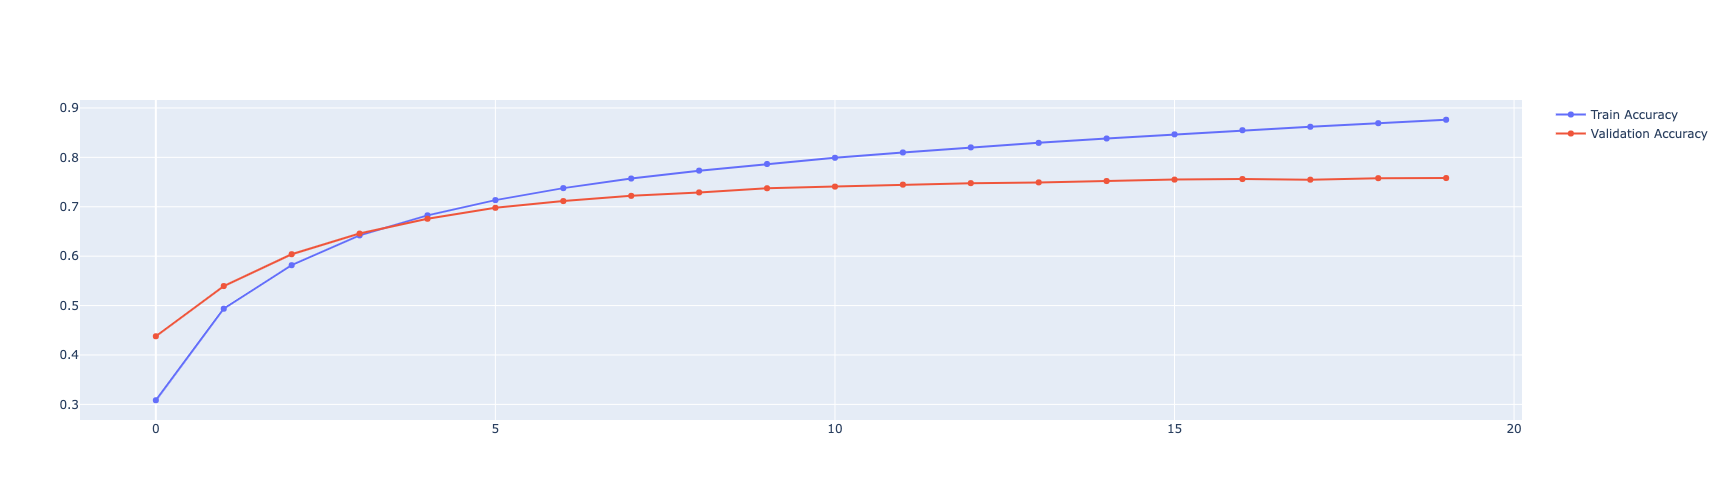

In [28]:
get_model_metrics(y_val, model_tf_idf.predict(X_val_tf_idf_tensor), full_report = 0, plot = 1)